In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms


In [3]:
class FruitDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label


In [4]:
# Function to load and preprocess images
def load_images(folder_path, label):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        img = cv2.imread(os.path.join(folder_path, filename))
        img = cv2.resize(img, (100, 100))  # Resize image to 100x100
        if img is not None:
            images.append(img)
            labels.append(label)
    return images, labels


In [5]:
ripen_images, ripen_labels = load_images('/content/drive/MyDrive/Colab Notebooks/unripe_ripe/New folder/ripe', 0)  # Ripe fruits labeled as 0
unripen_images, unripen_labels = load_images('/content/drive/MyDrive/Colab Notebooks/unripe_ripe/New folder/unripe', 1)  # Unripe fruits labeled as 1


In [6]:
# Combine images and labels
images = np.array(ripen_images + unripen_images)
labels = np.array(ripen_labels + unripen_labels)


In [7]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)


In [8]:
# Define transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create datasets
train_dataset = FruitDataset(X_train, y_train, transform=transform)
test_dataset = FruitDataset(X_test, y_test, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [9]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 25 * 25, 128)
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 25 * 25)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
criterion = nn.BCELoss()  # Binary Cross Entropy for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [11]:
num_epochs = 20
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device, dtype=torch.float32).unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device, dtype=torch.float32).unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_losses.append(val_loss / len(test_loader))

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}")


Epoch [1/20], Train Loss: 0.4729, Validation Loss: 0.3858
Epoch [2/20], Train Loss: 0.3412, Validation Loss: 0.3567
Epoch [3/20], Train Loss: 0.3056, Validation Loss: 0.3461
Epoch [4/20], Train Loss: 0.2891, Validation Loss: 0.3868
Epoch [5/20], Train Loss: 0.2613, Validation Loss: 0.3377
Epoch [6/20], Train Loss: 0.1957, Validation Loss: 0.3641
Epoch [7/20], Train Loss: 0.1497, Validation Loss: 0.3844
Epoch [8/20], Train Loss: 0.1068, Validation Loss: 0.4559
Epoch [9/20], Train Loss: 0.0711, Validation Loss: 0.4468
Epoch [10/20], Train Loss: 0.0559, Validation Loss: 0.4829
Epoch [11/20], Train Loss: 0.0452, Validation Loss: 0.4855
Epoch [12/20], Train Loss: 0.0375, Validation Loss: 0.5694
Epoch [13/20], Train Loss: 0.0377, Validation Loss: 0.6740
Epoch [14/20], Train Loss: 0.0321, Validation Loss: 0.5989
Epoch [15/20], Train Loss: 0.0237, Validation Loss: 0.7114
Epoch [16/20], Train Loss: 0.0220, Validation Loss: 0.6978
Epoch [17/20], Train Loss: 0.0252, Validation Loss: 0.5515
Epoch 

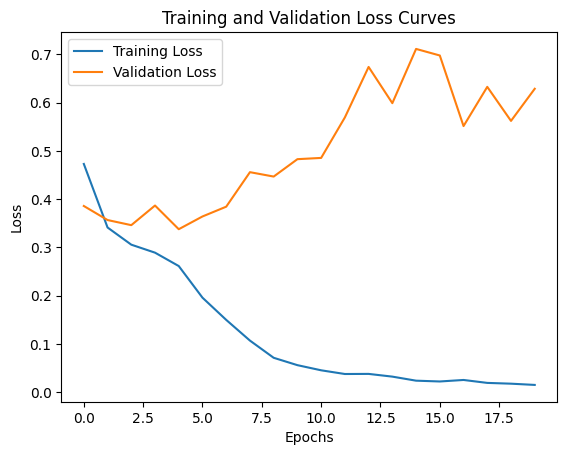

In [12]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()


In [33]:
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import transforms
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
class FruitDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label


In [35]:
def load_images(folder_path, label):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        img = cv2.imread(os.path.join(folder_path, filename))
        img = cv2.resize(img, (100, 100))  # Resize image to 100x100
        if img is not None:
            images.append(img)
            labels.append(label)
    return images, labels

ripen_images, ripen_labels = load_images('/content/drive/MyDrive/Colab Notebooks/unripe_ripe/New folder/ripe', 0)
unripen_images, unripen_labels = load_images('/content/drive/MyDrive/Colab Notebooks/unripe_ripe/New folder/unripe/', 1)

# Combine images and labels
images = np.array(ripen_images + unripen_images)
labels = np.array(ripen_labels + unripen_labels)


In [36]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Data augmentation for training set
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

# Only normalization for testing set
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])

train_dataset = FruitDataset(X_train, y_train, transform=train_transform)
test_dataset = FruitDataset(X_test, y_test, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [37]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 25 * 25, 128)
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x


In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [39]:
num_epochs = 20
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss, correct = 0.0, 0
    for images, labels in train_loader:
        images, labels = images.to(device).float(), labels.to(device).float().unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(correct / len(train_dataset))

    model.eval()
    val_loss, correct = 0.0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device).float(), labels.to(device).float().unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()

    val_losses.append(val_loss / len(test_loader))
    val_accuracies.append(correct / len(test_dataset))

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, "
          f"Val Loss: {val_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, "
          f"Val Acc: {val_accuracies[-1]:.4f}")


Epoch 1/20, Train Loss: 0.4714, Val Loss: 0.4445, Train Acc: 0.7890, Val Acc: 0.8157
Epoch 2/20, Train Loss: 0.3645, Val Loss: 0.4108, Train Acc: 0.8432, Val Acc: 0.8209
Epoch 3/20, Train Loss: 0.3453, Val Loss: 0.3706, Train Acc: 0.8513, Val Acc: 0.8325
Epoch 4/20, Train Loss: 0.3574, Val Loss: 0.4489, Train Acc: 0.8510, Val Acc: 0.8222
Epoch 5/20, Train Loss: 0.3456, Val Loss: 0.3758, Train Acc: 0.8603, Val Acc: 0.8247
Epoch 6/20, Train Loss: 0.3253, Val Loss: 0.3587, Train Acc: 0.8616, Val Acc: 0.8518
Epoch 7/20, Train Loss: 0.3140, Val Loss: 0.3332, Train Acc: 0.8687, Val Acc: 0.8531
Epoch 8/20, Train Loss: 0.3066, Val Loss: 0.3771, Train Acc: 0.8732, Val Acc: 0.8299
Epoch 9/20, Train Loss: 0.3054, Val Loss: 0.3399, Train Acc: 0.8723, Val Acc: 0.8595
Epoch 10/20, Train Loss: 0.2824, Val Loss: 0.4020, Train Acc: 0.8816, Val Acc: 0.8299
Epoch 11/20, Train Loss: 0.2747, Val Loss: 0.3582, Train Acc: 0.8774, Val Acc: 0.8402
Epoch 12/20, Train Loss: 0.2705, Val Loss: 0.3295, Train Acc: 0

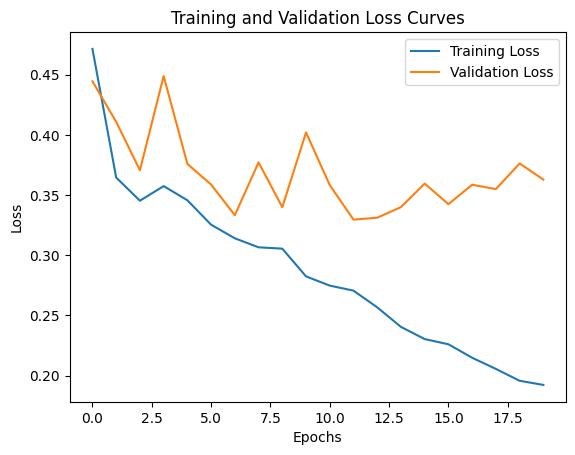

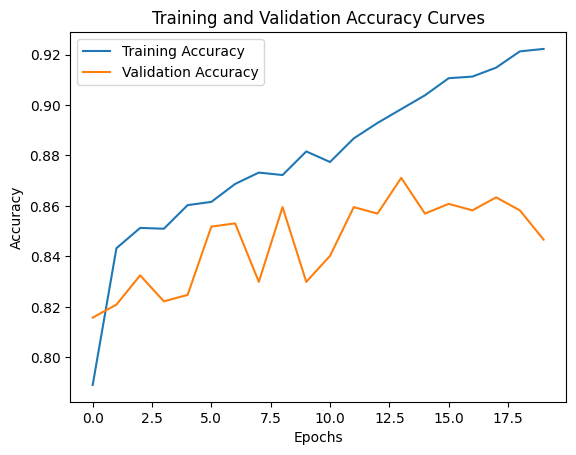

In [40]:
# Plot Loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

# Plot Accuracy
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Curves')
plt.legend()
plt.show()


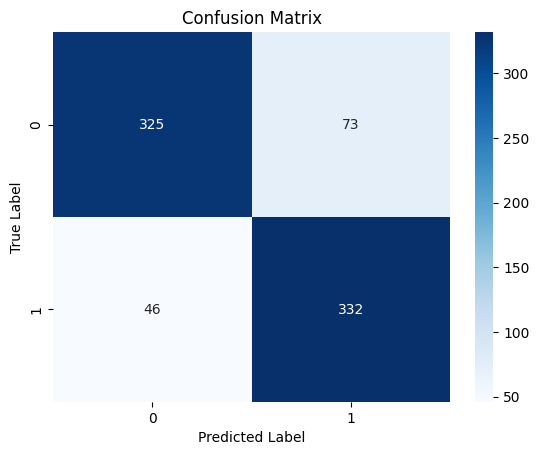

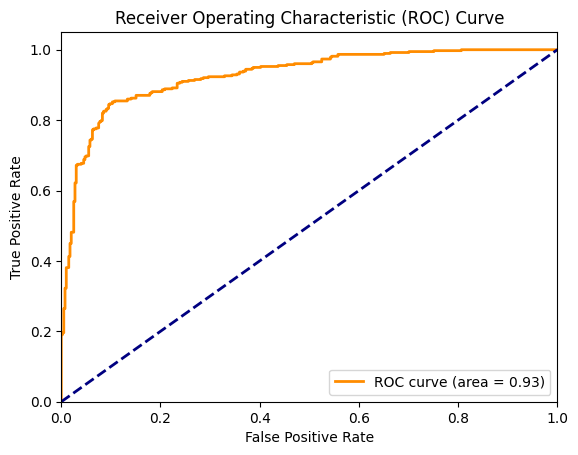

In [41]:
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device).float()
        outputs = model(images)
        y_true.extend(labels.numpy())
        y_pred.extend(outputs.cpu().numpy())

# Binarize predictions
y_pred_classes = (np.array(y_pred) > 0.5).astype(np.uint8)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [42]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Convert the true labels and predictions to numpy arrays if they aren't already
y_true = np.array(y_true)
y_pred_classes = np.array(y_pred_classes).flatten()  # Ensure predictions are in the correct format

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes)
recall = recall_score(y_true, y_pred_classes)
f1 = f1_score(y_true, y_pred_classes)
roc_auc = roc_auc_score(y_true, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"AUC: {roc_auc:.2f}")


Accuracy: 0.85
Precision: 0.82
Recall: 0.88
F1 Score: 0.85
AUC: 0.93
